In [ ]:
! unzip ./MNIST.zip_

In [4]:

import cv2

im = cv2.imread("0001.bmp")
print(im.shape)


(3510, 2550, 3)


name:  0_29_53.jpg
label:  0
<class 'numpy.ndarray'>
(28, 28)


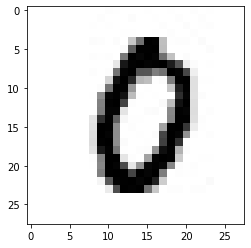

In [22]:
    import os
    import matplotlib.pyplot as plt
    from google.colab.patches import cv2_imshow

    currDir = "/content" # jupyter not ok

    root = os.path.join(currDir, "MNIST")

    names = os.listdir(root)

    for name in names:

        print("name: ", name)

        num = name.split('_')[0]  # number in fname already 
        num = int(num)

        print( "label: ", num )

        num = num / 10  # normalize number to 0.0 ~ 1.0

        path = os.path.join(root, name)
        im = cv2.imread(path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        print( type(im) )
        print(im.shape)
        #print(im)

        # cv2.imshow('image', im) # BUG: crash the colab kernel
        cv2_imshow(im)
        plt.imshow(im.squeeze(), cmap='gray_r'); 

        break

In [ ]:

"""
手写数字识别 pytorch 实现

reference:
    https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
    doc\lang\programming\pytorch\李宏毅2020机器翻译\iAttention.py
    doc\lang\programming\pytorch\数字识别\ihandwritten_digit_recognition_GPU.ipynb
    https://gist.github.com/user01/68514db1127eb007f24d28bfd11dd60e


MNIST 图片的导出（）
# import cv2

# print( images.shape[0] )

# for j in range(30):
  
#   images, labels = next(dataiter)

#   for i in range(images.shape[0]):
#     a = ((images[i].numpy().squeeze() + 1) / 2) * 255  # 原来的数值范围是 -1.0 ~ +1.0 ，规范为 0 ~ 255
#     b = np.rint(a)  # Round elements of the array to the nearest integer.
#     #plt.imshow(b, cmap='gray_r')
#     #b
#     label = labels.numpy()[i]
#     #print(label)
#     #cv2.imshow('Binary Threshold', b)
#     cv2.imwrite(f'./out/{label}_{j}_{i}.jpg',b)

"""
import torch
from torch.types import Number
import torch.utils.data as torch_data
from torch import nn
from torch import optim

from time import time
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def Data(type='training'):

    #currDir = os.getcwd() # jupyter is ok
    #currDir = os.path.dirname(os.path.abspath(__file__)) # jupyter not ok



    currDir = "/content" # jupyter not ok

    root = os.path.join(currDir, "MNIST")

    names = os.listdir(root)

    for name in names:

        print("name: ", name)

        num = name.split('_')[0]  # number in fname already 
        num = int(num)

        print( "label: ", num )

        num = num / 10  # normalize number to 0.0 ~ 1.0

        path = os.path.join(root, name)
        im = cv2.imread(path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        #print( type(im) )
        #print(im.shape)
        #print(im)

        # cv2.imshow('image', im) # BUG: crash the colab kernel
        #cv2_imshow(im)
        #plt.imshow(im.squeeze(), cmap='gray_r');

        break


    data = [
        [ torch.Tensor([0, 0]), torch.Tensor([0]) ],
        [ torch.Tensor([0, 1]), torch.Tensor([1]) ],
        [ torch.Tensor([1, 0]), torch.Tensor([1]) ],
        [ torch.Tensor([1, 1]), torch.Tensor([0]) ]
    ]

    return data

class TorchDataset(torch_data.Dataset):
  def __init__(self, data):
    self.data = data
        
  def __len__(self):
    return len(self.data)
  def __getitem__(self, Index):
    item = self.data[Index]

    return item[0], item[1]

def infinite_iter(data_loader):
  it = iter(data_loader)
  while True:
    try:
      item_in , item_out = next(it)
      yield item_in, item_out
    except StopIteration:
      it = iter(data_loader)

# Layer details for the neural network
input_size = 2 # 输入层两个神经元
# hidden_sizes = [128, 64] # 没有隐层
output_size = 1 # 输出一个值

# Build a feed-forward network
model = nn.Sequential(
  nn.Linear(2, 8),
  nn.ReLU(),
  nn.Linear(8, 1)
)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)



train_dataset = TorchDataset(Data(type='training'))
train_loader = torch_data.DataLoader(train_dataset, batch_size = 4, shuffle=True)  # 每个输入是维度是(2) 的一维数组，每一批输入2 组 来训练
train_iter = infinite_iter(train_loader)

sources, targets = next(train_iter)

print( sources, targets )


optimizer = optim.SGD(model.parameters(), lr=0.05) # momentum=0.05
criterion = nn.MSELoss() #nn.NLLLoss()  # https://zhuanlan.zhihu.com/p/264366034
  # NLLloss 和交叉熵一样只适用于分类任务， NLLLoss是基于softmax，softmax得到结果向量的概率分布，是离散值。回归任务建议MSE或MAE等损失函数
  # 否则提示多个target报错

time0 = time()
epochs = 10000

# 训练模型
for e in range(epochs):
    running_loss = 0
    sources, targets = next(train_iter)

    #targets = targets.squeeze(1) # 降维
    #targets = targets.to(device=device, dtype=torch.long)
    #targets =torch.tensor(targets, dtype=torch.long) # 类型转换

    # Training pass
    optimizer.zero_grad()
        
    output = model( sources.cuda() if torch.cuda.is_available() else sources.cpu() )
    loss = criterion(output,  targets.cuda() if torch.cuda.is_available() else targets.cpu() )
    #This is where the model learns by backpropagating
    loss.backward()
        
    #And optimizes its weights here
    optimizer.step()
        
    running_loss += loss.item()
    
    print("Epoch {} - Training loss: {}".format(e, running_loss/4)) # 4 是总样本数

print("\nTraining Time (in minutes) =",(time()-time0)/60)


# 保存训练好的参数
torch.save(model.state_dict(), "save_OR_torch.pt")

# 验证训练出的模型是否正确
sources, targets = next(train_iter)
with torch.no_grad():
    
    # 加载训练好的参数
    model.load_state_dict(torch.load("save_OR_torch.pt"))
    model.eval()

    output = model( sources.cuda() if torch.cuda.is_available() else sources.cpu() )
    print( sources, output )


